In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy, AUC
from sklearn.model_selection import train_test_split

In [2]:
# Add an additional column, mapping to the type
Image_info_df = pd.read_csv('../Data/Gaussian_Retina_Data/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


Image_info_df['binary_type'] =  Image_info_df['diagnosis'].map(diagnosis_dict_binary.get)
Image_info_df['type'] = Image_info_df['diagnosis'].map(diagnosis_dict.get)
Image_info_df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


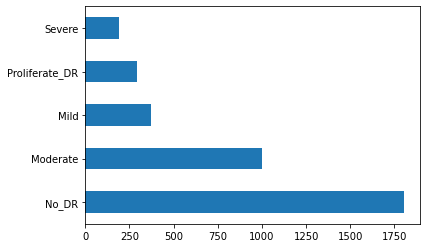

In [3]:
# Show how many of each type of retinopathy
Image_info_df['type'].value_counts().plot(kind='barh')

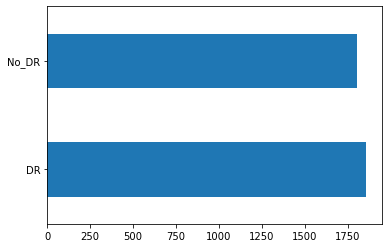

In [4]:
# Show the balance between no retinopathy and stages of retinopathy
Image_info_df['binary_type'].value_counts().plot(kind='barh')

In [5]:
# Split into train, and test sets
train, test = train_test_split(Image_info_df, test_size = 0.20)

# Show how many in each set
print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')

No_DR             1441
Moderate           799
Mild               301
Proliferate_DR     239
Severe             149
Name: type, dtype: int64 

No_DR             364
Moderate          200
Mild               69
Proliferate_DR     56
Severe             44
Name: type, dtype: int64 



In [6]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [7]:
# Copy images to respective working directory
src_dir = '../Data/Gaussian_Retina_Data/gaussian_filtered_images/gaussian_filtered_images/'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [8]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = False)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2929 images belonging to 5 classes.
Found 733 images belonging to 5 classes.


# 8 Layer CNN Model

In [9]:
# Building the model

model = models.Sequential([
    layers.Conv2D(16, (3, 3), padding="same", activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(1, 1)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(8, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')

])

# Show the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9

In [10]:
# Compile and Execute the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=200,
                    validation_data=test_batches)

Epoch 1/200
92/92 [==============================] - 122s 1s/step - loss: 0.7582 - acc: 0.1137 - val_loss: 0.6926 - val_acc: 0.0764
Epoch 2/200
92/92 [==============================] - 128s 1s/step - loss: 0.7235 - acc: 0.1144 - val_loss: 0.6847 - val_acc: 0.0764
Epoch 3/200
92/92 [==============================] - 140s 2s/step - loss: 0.7033 - acc: 0.1219 - val_loss: 0.6881 - val_acc: 0.0819
Epoch 4/200
92/92 [==============================] - 141s 2s/step - loss: 0.6878 - acc: 0.1250 - val_loss: 0.6991 - val_acc: 0.0982
Epoch 5/200
92/92 [==============================] - 130s 1s/step - loss: 0.6765 - acc: 0.1321 - val_loss: 0.7165 - val_acc: 0.1119
Epoch 6/200
92/92 [==============================] - 103s 1s/step - loss: 0.6672 - acc: 0.1287 - val_loss: 0.7142 - val_acc: 0.1364
Epoch 7/200
92/92 [==============================] - 98s 1s/step - loss: 0.6583 - acc: 0.1338 - val_loss: 0.7035 - val_acc: 0.1774
Epoch 8/200
92/92 [==============================] - 98s 1s/step - loss: 0.65

In [11]:
# Show the final accuracy of the model
acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc[1])

23/23 [==============================] - 7s 300ms/step - loss: 0.4777 - acc: 0.5143
Accuracy:  0.5143246650695801


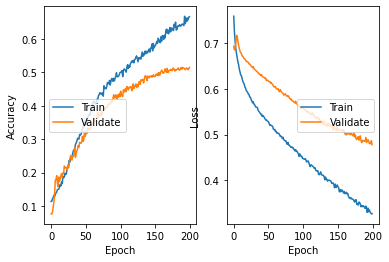

In [12]:
# plot the graphs of how the solution converges: Accuracy and Loss for the training and test data

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center right')


In [13]:
#  Predict the label of the test_images
pred = model.predict(test_batches)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

The first 10 predictions: ['Proliferate_DR', 'No_DR', 'Proliferate_DR', 'Severe', 'Proliferate_DR', 'Proliferate_DR', 'No_DR', 'Severe', 'No_DR', 'Severe']


In [14]:
# Save the model
model.save("Retinopathy_model_trained_200.h5")

In [15]:
# Load the model
from tensorflow.keras.models import load_model
retinopathy_model = load_model("Retinopathy_model_trained_200.h5")

In [16]:
model_loss, model_accuracy = retinopathy_model.evaluate(
    test_batches, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

23/23 - 7s - loss: 0.4777 - acc: 0.5143
Normal Neural Network - Loss: 0.47771576046943665, Accuracy: 0.5143246650695801


In [17]:
df=pd.DataFrame.from_dict(history.history, orient="index")
df.to_csv("200_history_data.csv")

In [19]:
reload_history=pd.read_csv("200_history_data.csv", index_col=0)
reload_history

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
loss,0.758151,0.723468,0.703276,0.687834,0.676530,0.667212,0.658265,0.652577,0.642991,0.636487,...,0.343898,0.338126,0.330218,0.339683,0.331363,0.335606,0.331470,0.329284,0.326747,0.327194
acc,0.113691,0.114374,0.121885,0.124957,0.132127,0.128713,0.133834,0.139297,0.141345,0.149198,...,0.641857,0.639467,0.667463,0.645271,0.662001,0.651758,0.662001,0.656879,0.664732,0.666098
val_loss,0.692562,0.684705,0.688095,0.699078,0.716522,0.714211,0.703471,0.694537,0.688101,0.681864,...,0.493317,0.482999,0.486228,0.488793,0.486829,0.480806,0.479899,0.480870,0.486454,0.477716
val_acc,0.076398,0.076398,0.081855,0.098226,0.111869,0.136426,0.177353,0.178718,0.190996,0.169168,...,0.512960,0.512960,0.510232,0.507503,0.510232,0.512960,0.510232,0.507503,0.510232,0.514325


In [20]:
new_history = reload_history.to_dict("split")

new_history = dict(zip(new_history["index"], new_history["data"]))

In [21]:
import csv
with open("200_pred.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(pred)

In [1]:
train_path = 'train'
test_path = 'test'

train_x_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = False)
test_x_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

NameError: name 'ImageDataGenerator' is not defined